In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import pyreadr

from load_data import open_charac, add_general_charac
from binaryclass_memory import *

## Load data

In [2]:
general_charac = pyreadr.read_r('../data/Characteristics_masterfiles/General_characteristics/EPFL_gene_master_matrix.RData')['gene_master_matrix']

names = ['AE3', 'AE4', 'AE7', 'BIDDY_D0', 'BIDDY_D0_2', 'BIDDY_D6', 'BIDDY_D6_2', 'BIDDY_D15', 'BIDDY_D15_2',
        'LK_D2_exp1_library_d2_1', 'LK_D2_exp1_library_d2_2', 'LK_D2_exp1_library_d2_3', 'LK_LSK_D2_exp3_library_d2_1', 
        'LK_LSK_D2_exp3_library_d2_2', 'LK_LSK_D2_exp3_library_d2_3', 'LK_LSK_D2_exp3_library_d2_4', 
        'LK_LSK_D2_exp3_library_d2_5', 'LSK_D2_exp1_library_LSK_d2_1', 'LSK_D2_exp1_library_LSK_d2_2', 'LSK_D2_exp1_library_LSK_d2_3',
       'LSK_D2_exp2_library_d2A_1', 'LSK_D2_exp2_library_d2A_2', 'LSK_D2_exp2_library_d2A_3' , 'LSK_D2_exp2_library_d2A_4', 'LSK_D2_exp2_library_d2A_5', 
       'LSK_D2_exp2_library_d2B_1','LSK_D2_exp2_library_d2B_2', 'LSK_D2_exp2_library_d2B_3', 'LSK_D2_exp2_library_d2B_4', 'LSK_D2_exp2_library_d2B_5']
charac_matrix = []
norm_matrix = []
families_matrix = []
for name in names:
    #Open characteristics file
    charac_out_path = '../data/Characteristics_masterfiles/Dataset_specific_characteristics/' + name + '__characteristics_output.txt'
    p_value_path = '../data/Characteristics_masterfiles/Memory_genes/P_value_estimate_CV2_ofmeans_' + name + '.txt'
    charac_matrix.append(open_charac(charac_out_path, p_value_path, 200))
    
    #Open normalized data
    norm_path = '../data/merged_data/' + name + '.csv'
    fam_path = '../data/merged_data/y_' + name + '.csv'
    norm = pd.read_csv (norm_path)
    norm = norm.set_index('Unnamed: 0')
    families= np.squeeze(np.array(pd.read_csv(fam_path)))
    
    norm_matrix.append(norm)
    families_matrix.append(families)

In [3]:
#Add general characteristic
for i in range(0,len(charac_matrix)):
    charac_matrix[i] = add_general_charac(charac_matrix[i], general_charac)
    charac_matrix[i] = charac_matrix[i].drop(['CV2ofmeans_residuals','cell_cycle_dependence', 'skew', 'CV2ofmeans', 'exon_expr_median', 'exon_expr_mean'], axis=1)
    charac_matrix[i] = charac_matrix[i].dropna()

# Visualization data

AE3


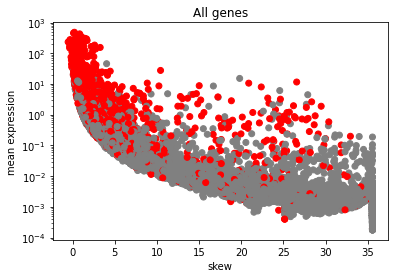

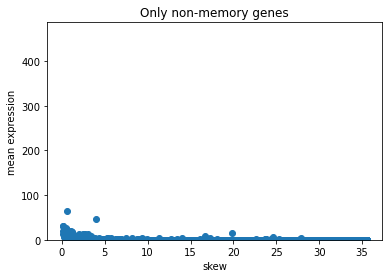

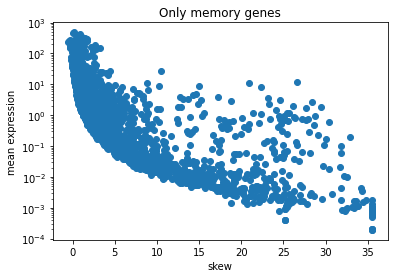

AE4


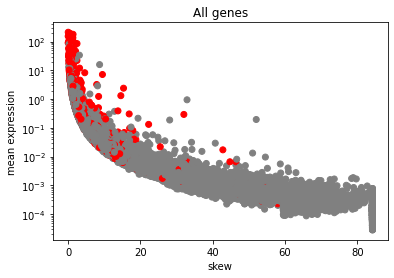

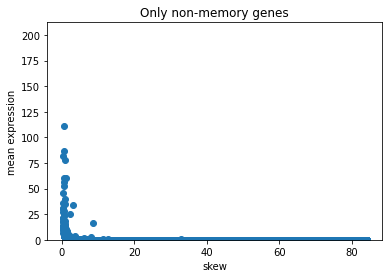

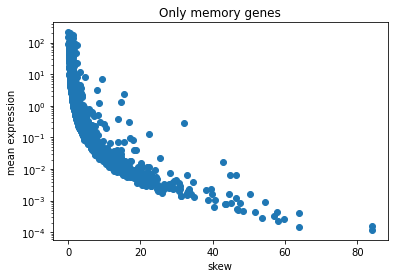

AE7


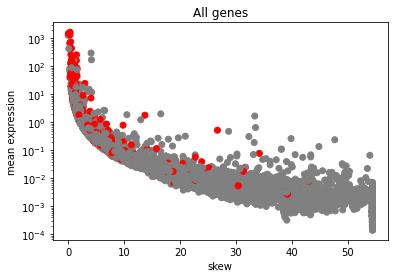

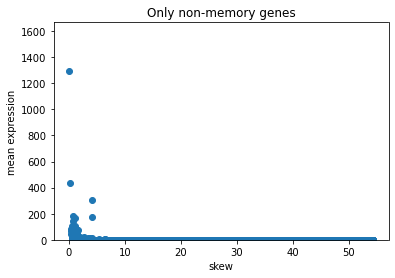

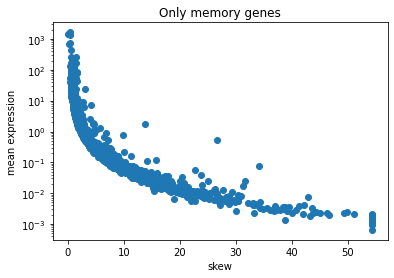

BIDDY_D0


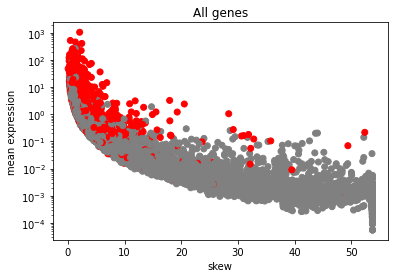

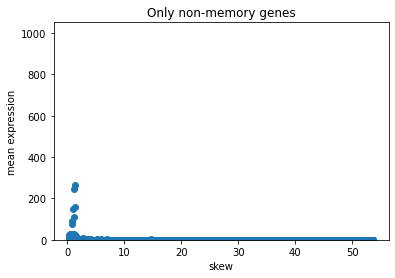

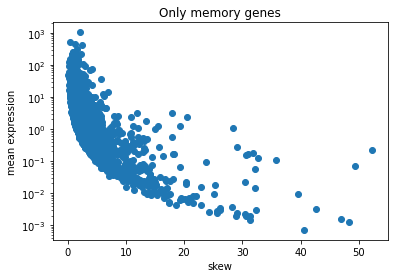

BIDDY_D0_2


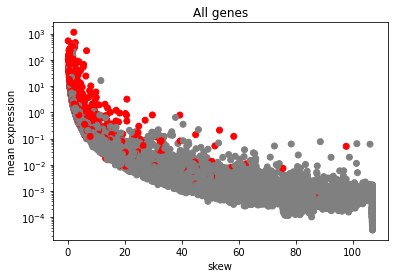

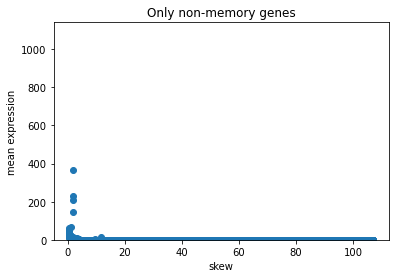

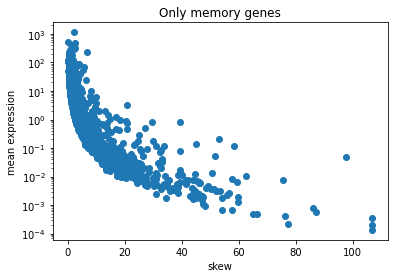

BIDDY_D6


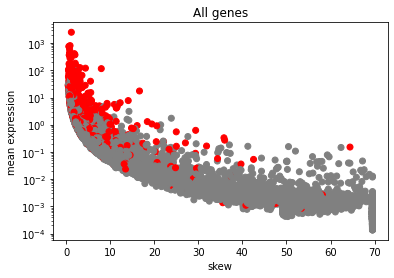

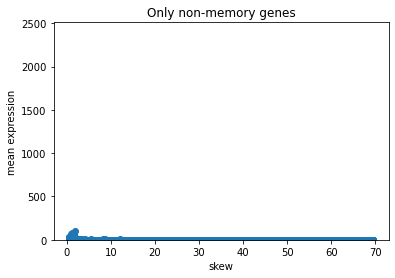

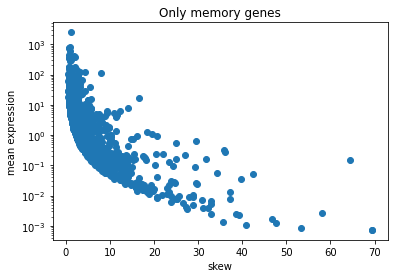

BIDDY_D6_2


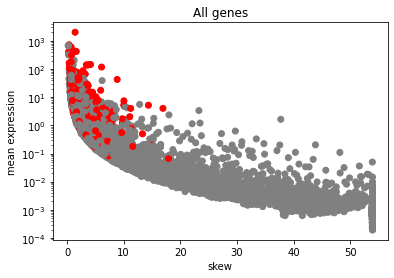

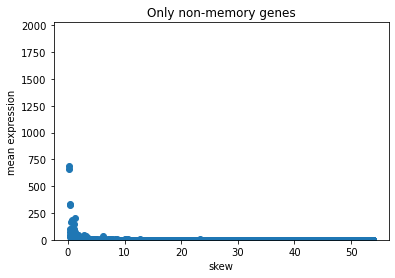

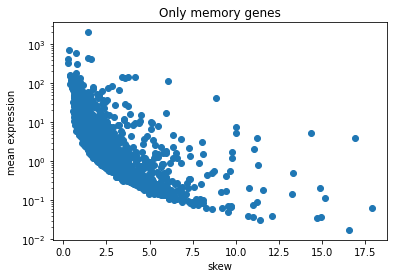

BIDDY_D15


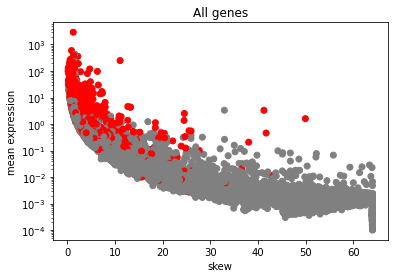

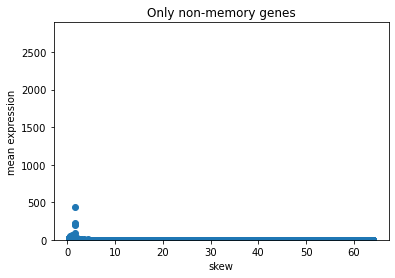

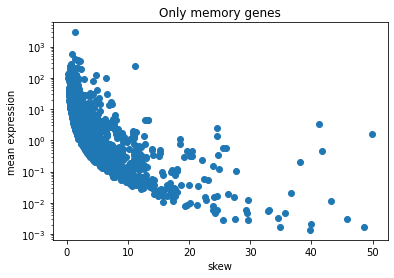

BIDDY_D15_2


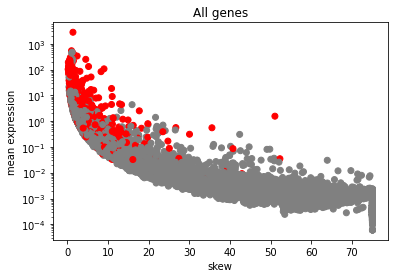

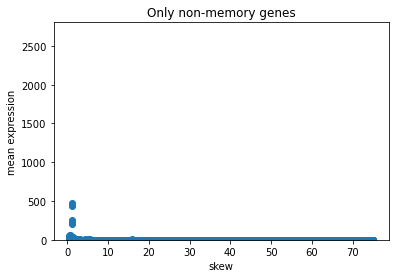

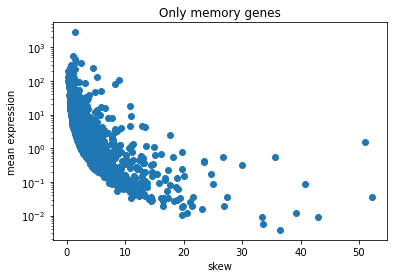

LK_D2_exp1_library_d2_1


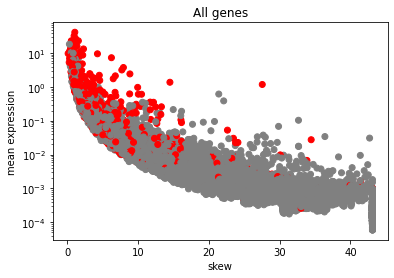

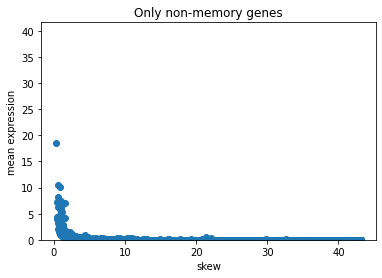

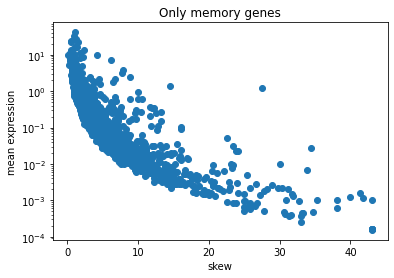

LK_D2_exp1_library_d2_2


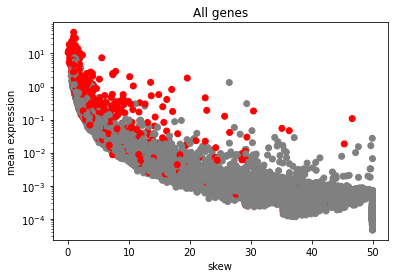

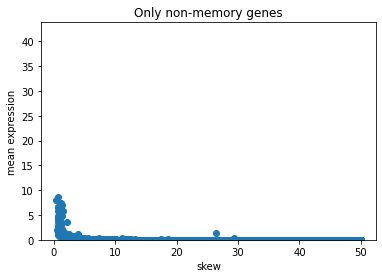

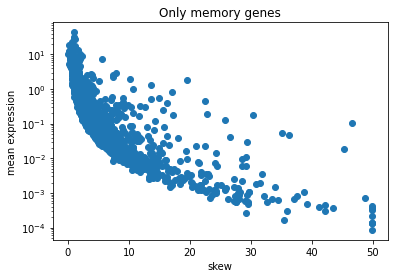

LK_D2_exp1_library_d2_3


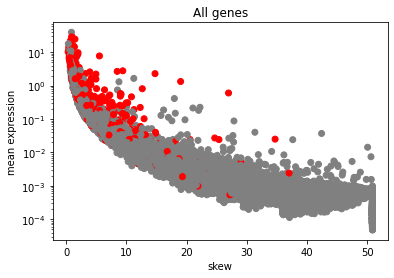

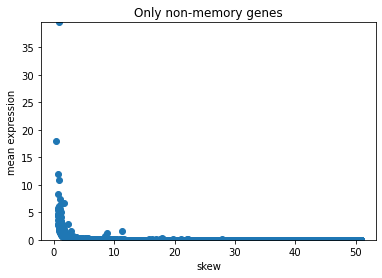

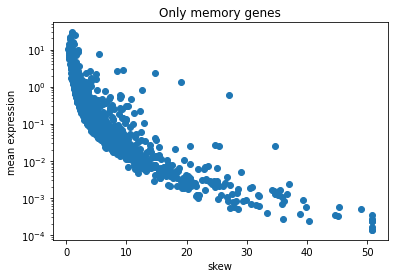

LK_LSK_D2_exp3_library_d2_1


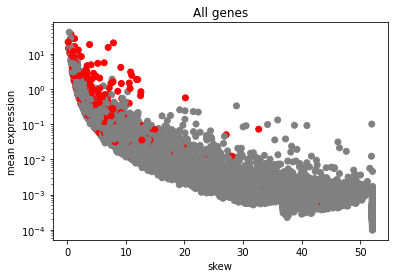

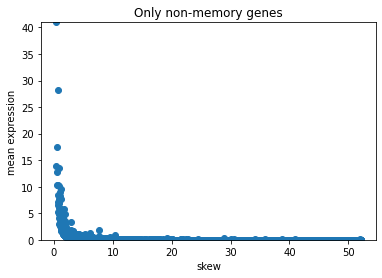

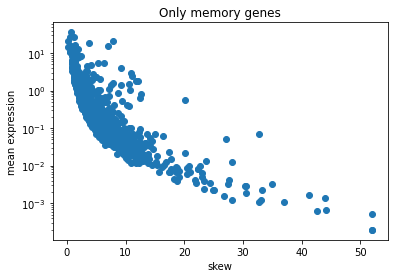

LK_LSK_D2_exp3_library_d2_2


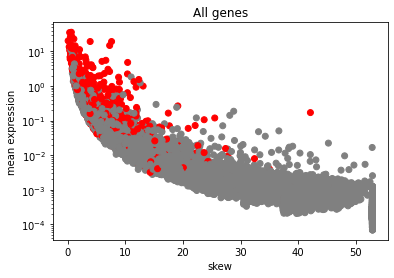

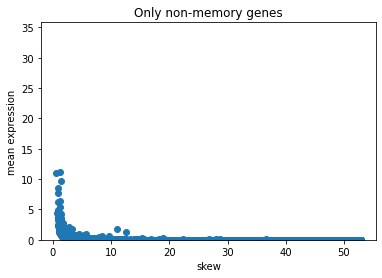

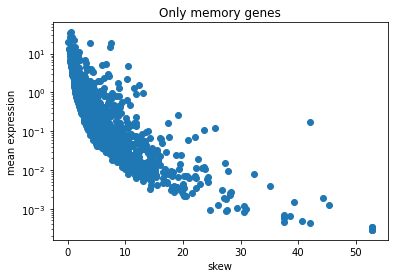

LK_LSK_D2_exp3_library_d2_3


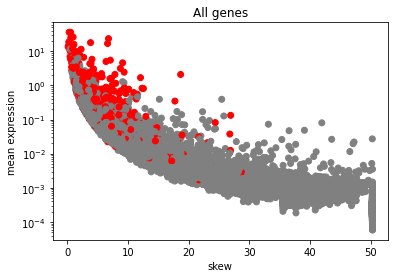

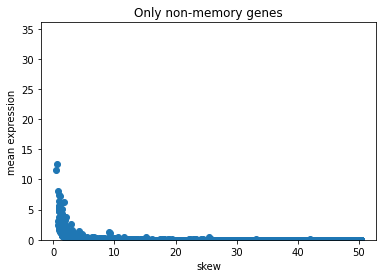

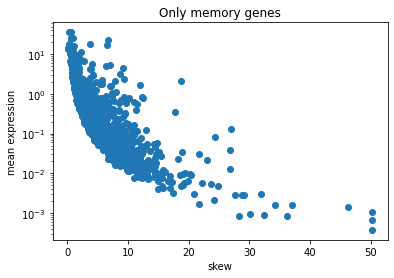

LK_LSK_D2_exp3_library_d2_4


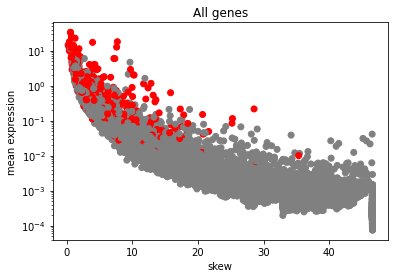

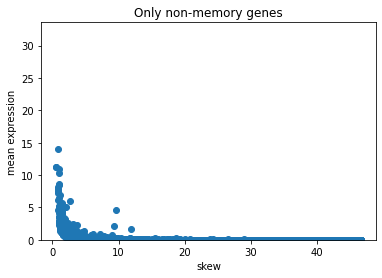

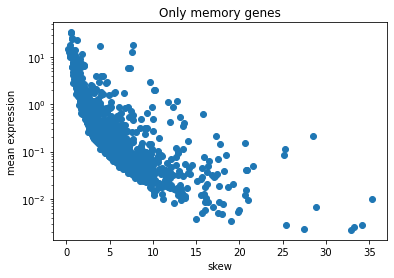

LK_LSK_D2_exp3_library_d2_5


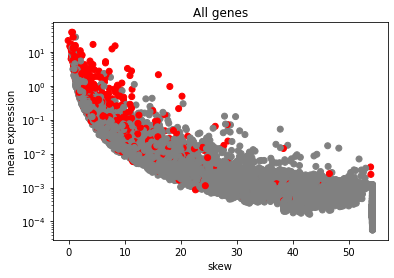

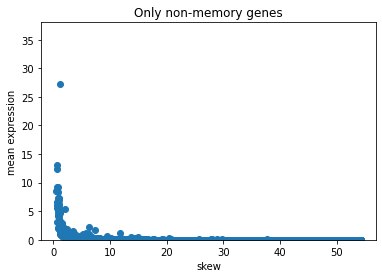

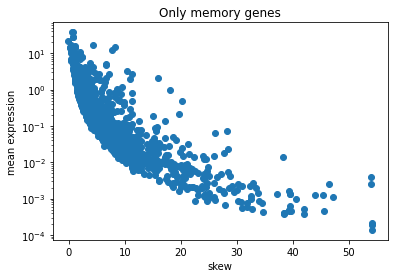

LSK_D2_exp1_library_LSK_d2_1


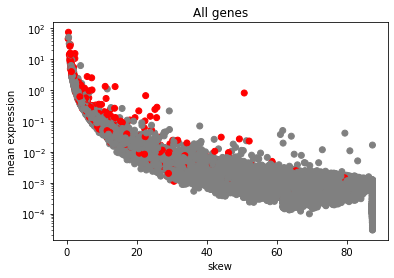

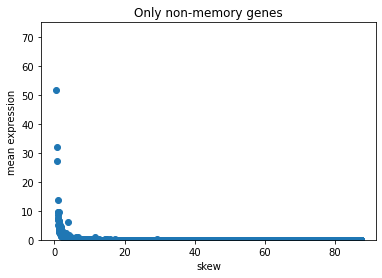

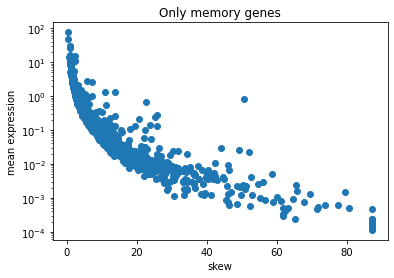

LSK_D2_exp1_library_LSK_d2_2


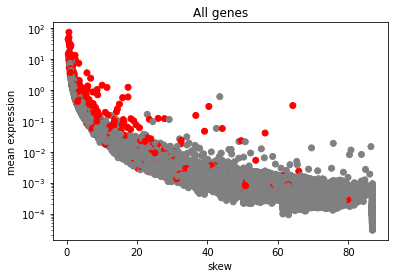

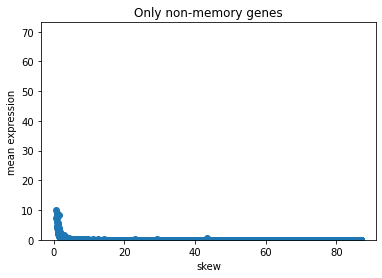

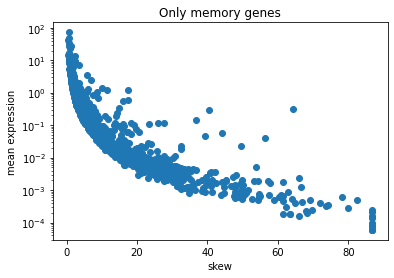

LSK_D2_exp1_library_LSK_d2_3


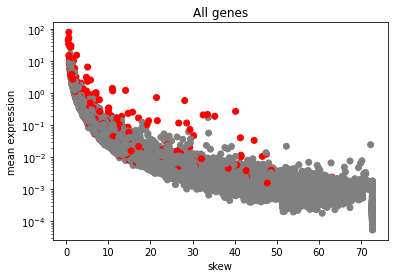

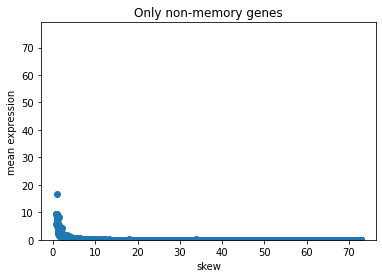

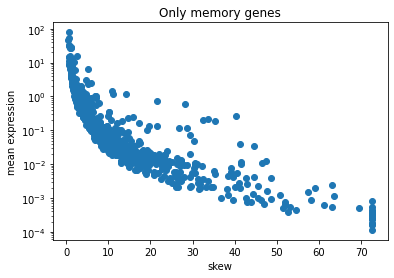

LSK_D2_exp2_library_d2A_1


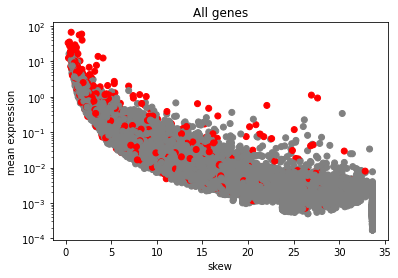

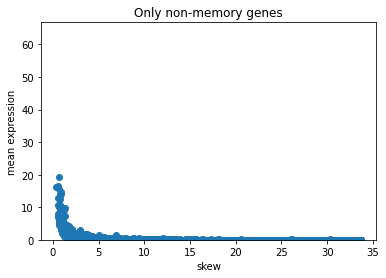

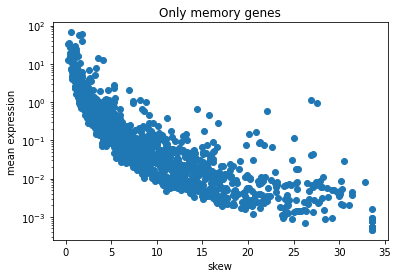

LSK_D2_exp2_library_d2A_2


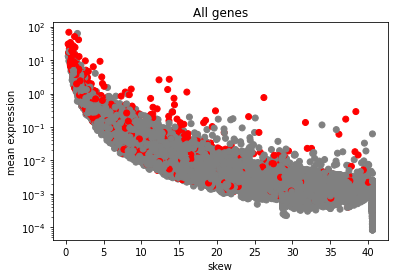

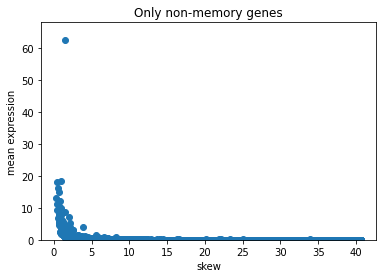

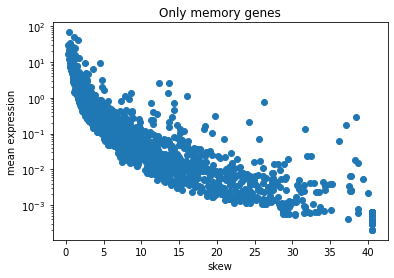

LSK_D2_exp2_library_d2A_3


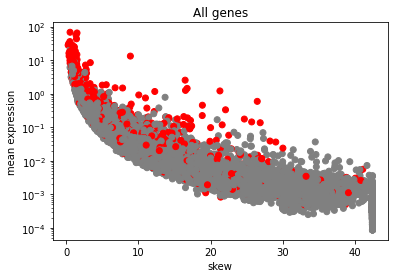

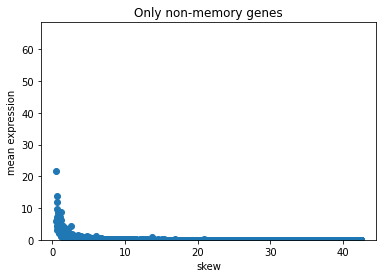

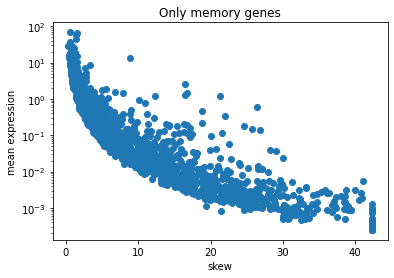

LSK_D2_exp2_library_d2A_4


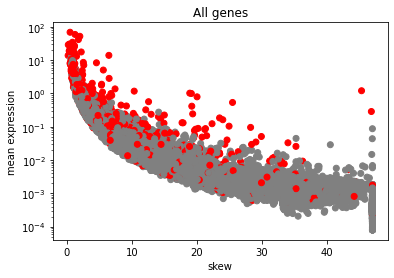

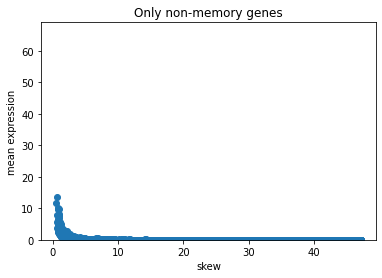

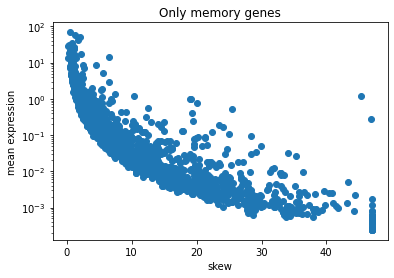

LSK_D2_exp2_library_d2A_5


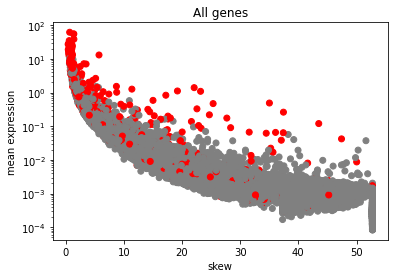

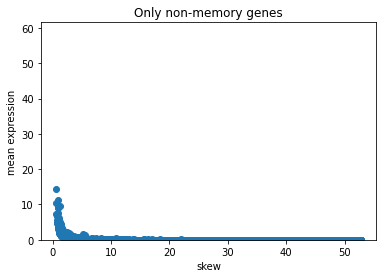

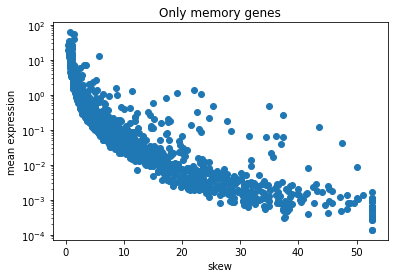

LSK_D2_exp2_library_d2B_1


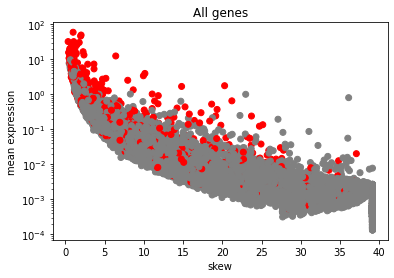

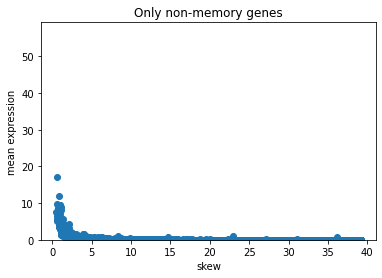

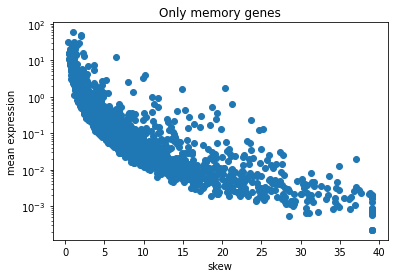

LSK_D2_exp2_library_d2B_2


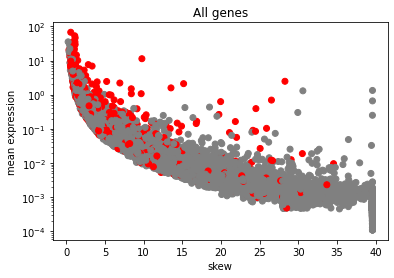

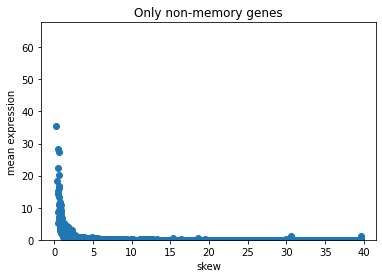

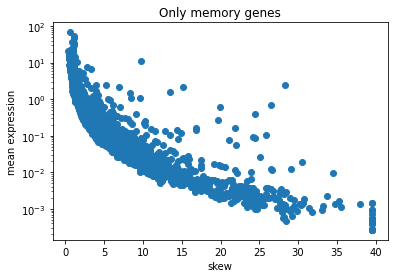

LSK_D2_exp2_library_d2B_3


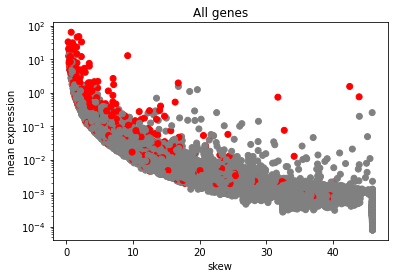

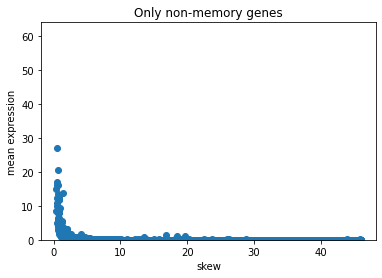

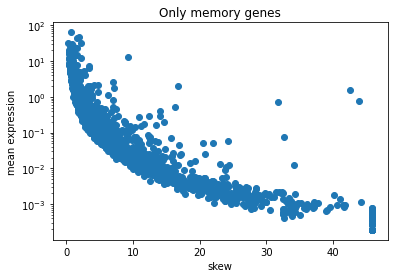

LSK_D2_exp2_library_d2B_4


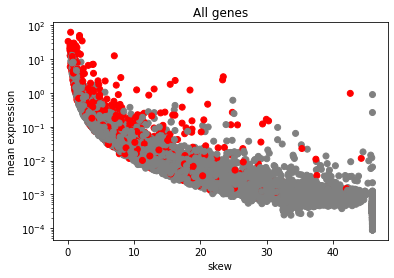

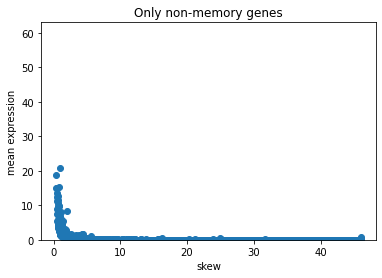

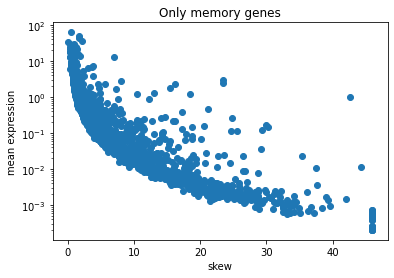

LSK_D2_exp2_library_d2B_5


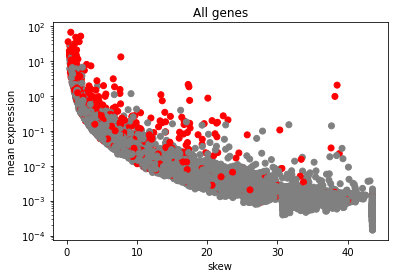

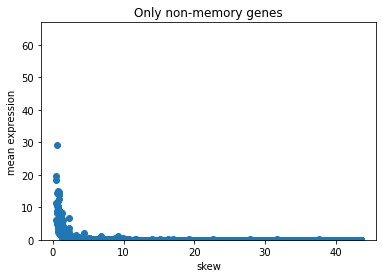

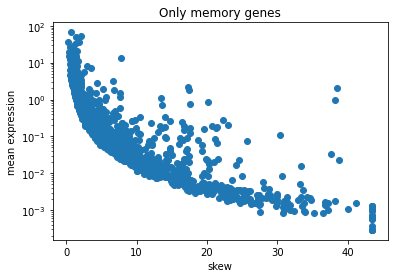

In [3]:
for i,charac in enumerate(charac_matrix):
    print(names[i])
    visualize_charac(charac)

# Logistic regression

In [45]:
feat = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
score = fit_evaluate(charac_matrix[0], norm_matrix[0], families_matrix[0], 'logreg', [0,1], penalty = 'l2', lamb = 1, verbose =True)

accuracy:  0.7319574411547753
recovery memory genes:  0.5783535311324697
false postive:  3249
Precision and recovery clustering:  0.42857142857142855 0.6066066066066066


In [16]:
#Select the features with highest clustering precision
indices_max = []
for i, data in enumerate(charac_matrix):
    feat_sets =[[4,5],[3,5],[1,5],[2,5],[1,2,5],[3,4,5],[1,3,5],[2,4,5],[1,2,3,4,5]]
    name_feat = [list(data[0].iloc[: , feat].columns) for feat in feat_sets] 
    name_feat = [', '.join(names) for names in name_feat]
    scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']

    score_sets = []
    for feat in feat_sets:
        score_sets.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'logreg', feat, penalty = 'l2', lamb = 1, verbose = False))

    scores_df = pd.DataFrame(score_sets, index = name_feat, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/featSelecLogreg/' + names[i] + 'logreg.csv', index=True)
    
    #Get best features indices
    ind_max = np.squeeze(np.argmax(np.array(scores_df['Clustering precision'])))
    indices_max.append(feat_sets[ind_max])
    
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/featSeleclogreg/' + 'bestFeat' + '.csv', index=True)

In [46]:
#Try different penalties
feat = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
for i, data in enumerate(charac_matrix):
    penalty = ['l1', 'l2', 'none']
    scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']
    score_pen = []
    for pen in penalty:
            score_pen.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'logreg', feat, penalty = pen, lamb = 1, solver = 'saga', verbose = False))
    scores_df = pd.DataFrame(score_pen, index = penalty, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/tryPenalties/' + names[i] + '.csv', index=True)

C:\Users\alexi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\alexi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


KeyboardInterrupt: 

AE3
AE3


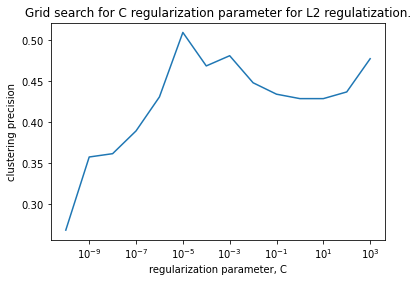

------
AE4


KeyboardInterrupt: 

In [65]:
#Grid search of penalty values
#L2 regularization
plot = True
scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']
feat = [0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

indices_max = []
for i, data in enumerate(charac_matrix):
    C = np.logspace(-10, 3, 14)
    scores_grid = []
    for lamb in C:
        scores_grid.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'logreg', feat, penalty = 'l2', lamb = lamb, verbose = False))
    
    scores_df = pd.DataFrame(scores_grid, index = C, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/L2reglogreg/' + names[i] + '.csv', index=True)
    
    #Get best best reg indices
    ind_max = np.squeeze(np.argmax(np.array(scores_df['Clustering precision']) + np.array(scores_df['Clustering recovery'])))
    indices_max.append(C[ind_max])
    
    if plot:
        print(names[i])
        plt.plot(C,scores_df['Clustering precision'])
        plt.title('Grid search for C regularization parameter for L2 regulatization.')
        plt.xlabel('regularization parameter, C')
        plt.xscale('log')
        plt.ylabel('clustering precision')
        plt.show()
        print('------')  
        
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/L2reglogreg/bestFeat.csv', index=True)

# Support vector machine

In [5]:
kernels = ['linear','rbf', 'poly', 'sigmoid']
for kern in kernels:

    print(kern)
    fit_evaluate(charac_matrix[0], norm_matrix[0], families_matrix[0], 'svm', [3,5], kernel = kern, verbose =True)

linear


KeyboardInterrupt: 

## RBF kernel

In [3]:
#Select the features with highest clustering precision
indices_max = []
for i, data in enumerate(charac_matrix):
    feat_sets =[[4,5],[3,5],[1,5],[2,5],[1,2,5],[3,4,5],[1,3,5],[2,4,5],[1,2,3,4,5]]
    name_feat = [list(data.iloc[: , feat].columns) for feat in feat_sets] 
    name_feat = [', '.join(names) for names in name_feat]
    scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']
    
    score_sets = []
    for feat in feat_sets:
        score_sets.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'svm', feat = feat, kernel = 'rbf', verbose =False))

    scores_df = pd.DataFrame(score_sets, index = name_feat, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/featSelecRBFSVM/' + names[i] + '.csv', index=True)
    
    #Get best features indices
    prec_rec = scores_df['Clustering precision'] + scores_df['Clustering recovery']
    ind_max = np.squeeze(np.argmax(np.array(prec_rec)))
    indices_max.append(feat_sets[ind_max])
    
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/featSelecRBFSVM/bestFeat.csv', index=True)

KeyError: 0

In [13]:
def fit_evaluate(data_charac:pd.DataFrame, norm:pd.DataFrame, family:np.array, fit_func:str, feat:list, penalty:str =None, lamb:float=1, solver:str='lbfgs', kernel:str='rbf', degree:int=3, gamma:int='scale', verbose:bool=True):
    data_charac = data_charac.dropna(subset=['skew_residuals', 'mean_expression'])
    X = np.array(data_charac.iloc[: , feat])
    Y = np.array(data_charac['memory_gene'])
    
    #Fit classifier to charac data
    if fit_func == 'logreg':
        clf, score = fit_logistic_reg(X, Y, penalty, lamb, solver)
    if fit_func == 'svm':
        clf, score = fit_svm(X, Y, lamb, kernel, degree, gamma)

    #Evaluate fitted classifier
    y = clf.predict(X)
    non_memory_gene = list(data_charac[data_charac['memory_gene'] == False].index)
    memory_gene = list(data_charac[data_charac['memory_gene'] == True].index)
    y = pd.DataFrame(y, index = data_charac.index, columns = ['pred'])
    y['true_label'] = Y

    y_non_mem = y.loc[non_memory_gene]
    y_mem = y.loc[memory_gene]
    recovery = np.sum(y_mem['pred'])/np.sum(y_mem['true_label'])
    false_pos = np.sum(y_non_mem['pred'])
    
    #Evaluate extracted subset on RNAseq Data
    gene_subset = list(y[y['pred']==True].index)
    
    if gene_subset:
        norm_subset = np.array(norm.loc[gene_subset].T)

        model = FamiliesClusters(np.unique(family),compute_precision,True)
        pred = model.fit_predict(norm_subset,family)
        precision, recovery = model.score_, model.recovery
    else:
        precision, recovery = np.NaN, np.NaN
    
    scores = [score, recovery, false_pos, precision, recovery]
    
    if verbose:
        print('accuracy: ',score)
        print('recovery memory genes: ', recovery)
        print('false postive: ', false_pos)
        print('Precision and recovery clustering: ', precision, recovery)
        
    return scores

In [14]:
#Grid search of penalty values
#L2 regularization
scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']
feat = [4,5]

indices_max = []
for i, data in enumerate(charac_matrix):
    C = np.logspace(-10, 3, 14)
    scores_grid = []
    for lamb in C:         
        scores_grid.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'svm', feat, lamb = lamb, kernel = 'rbf', verbose =False))
    
    scores_df = pd.DataFrame(scores_grid, index = C, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/RegRBFSVM/' + names[i] + '.csv', index=True)
    
    #Get best best reg indices
    ind_max = np.squeeze(np.argmax(np.array(scores_df['Clustering precision']) + np.array(scores_df['Clustering recovery'])))
    indices_max.append(C[ind_max]) 
        
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/RegRBFSVM/bestreg.csv', index=False)

yo
yo


KeyboardInterrupt: 

In [ ]:
#Grid search of gamma parameter for rbf kernel
plot = True
best_feat =  pd.read_csv('../data/binaryClass_scores/featSelecRBFSVM/bestFeat.csv')
best_feat = np.array(best_feat.set_index('Unnamed: 0'))
best_reg =  pd.read_csv('../data/binaryClass_scores/featSelecRBFSVM/bestreg.csv')
best_reg = np.array(best_reg.set_index('Unnamed: 0'))
scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']

indices_max = []
for i, data in enumerate(charac_matrix):
    C = np.logspace(-10, 3, 14)
    scores_grid = []
    for lamb in C:
        scores_grid.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'svm', feat = best_feat[i], lamb = best_reg[i], kernel = 'rbf', gamma = lamb,  verbose =False))
    
    scores_df = pd.DataFrame(scores_grid, index = C, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/gammaRBFSVM/' + names[i] + '.csv', index=True)
    
    #Get best best gamma indices
    prec_rec = scores_df['Clustering precision'] + scores_df['Clustering recovery']
    ind_max = np.squeeze(np.argmax(np.array(prec_rec)))
    indices_max.append(C[ind_max])
    
    if plot:
        print(names[i])
        plt.plot(C,scores_df['Clustering precision'])
        plt.title('Grid search for C regularization parameter for L2 regulatization.')
        plt.xlabel('regularization parameter, C')
        plt.xscale('log')
        plt.ylabel('clustering precision')
        plt.show()
        print('------')
        
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/gammaRBFSVM/bestFeat.csv', index=True)

## Polynomial kernel

In [ ]:
#Select the features with highest clustering precision
indices_max = []
for i, data in enumerate(charac_matrix):
    feat_sets =[[4,5],[3,5],[1,5],[2,5],[1,2,5],[3,4,5],[1,3,5],[2,4,5],[1,2,3,4,5]]
    name_feat = [list(data[0].iloc[: , feat].columns) for feat in feat_sets] 
    name_feat = [', '.join(names) for names in name_feat]
    scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']
    
    score_sets = []
    for feat in feat_sets:
        score_sets.append(fit_evaluate(data, norm_matrix[i], families_matrix[i], 'svm', feat = feat, kernel = 'poly', verbose =False))
        
    scores_df = pd.DataFrame(score_sets, index = name_feat, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/featSelecPolSVM/' + names[i] + '.csv', index=True)
    
    prec_rec = scores_df['Clustering precision'] + scores_df['Clustering recovery']
    ind_max = np.squeeze(np.argmax(np.array(prec_rec)))
    indices_max.append(feat_sets[ind_max])
    
    
pd.DataFrame(indices_max).to_csv('../data/binaryClass_scores/featSelecPolSVM/bestFeat.csv', index=True)

In [ ]:
#Grid search of penalty values and polynomial degree
scores = ['accuracy', 'recovery', 'FP', 'Clustering precision', 'Clustering recovery']

feat = [4,5]
C = np.logspace(-10, 3, 14)
degree = np.arange(2,8,1)

for d in degree:
    scores_grid = []
    for lamb in C:
        scores_grid.append(fit_evaluate(charac_matrix[0], norm_matrix[0], families_matrix[0], 'svm', feat = feat, lamb = lamb, kernel = 'poly', degree = d, verbose = False))

    scores_df = pd.DataFrame(scores_grid, index = C, columns= scores)
    scores_df.to_csv('../data/binaryClass_scores/RegPolSVM/' + names[0] + 'Degree' + str(d) + '.csv', index=False)

# Neural Network (NN)

In [71]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
import optuna

In [72]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, charac, labels):
        'Initialization'
        self.labels = labels
        self.charac = charac

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.charac)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.charac[index]
        y = self.labels[index]

        return X, y

In [73]:
def reset_weights(m):
    '''Try resetting model weights to avoid weight leakage.'''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

In [78]:
class NN(nn.Module):
    '''Simple Binary classification network'''
    
    def __init__(self,input_shape):
        super(NN,self).__init__()
        self.layers = nn.Sequential(
          nn.Linear(input_shape, 10),
          nn.ReLU(),
          nn.Linear(10, 8),
          nn.ReLU(),
          nn.Linear(8,1)
        )
    
    def forward(self,x):
        return self.layers(x)

In [137]:
# Set fixed random number seed
torch.manual_seed(1)

# Configuration options
k_folds = 5
num_epochs = 100 #1 only for testing need to be tune (normally way higher)

# For fold results
results = {}

#Load data into torch.Dataset
data = charac_matrix[0].dropna()
labels = (data['memory_gene']*1)
labels = np.expand_dims(labels, axis=1)
X = data.drop(['memory_gene'], axis=1)
dataset = Dataset(np.array(X), labels)

#Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

In [139]:
# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly 
    train_data = torch.utils.data.SubsetRandomSampler(train_ids)
    test_data = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=64, sampler=train_data)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=64, sampler=test_data)
    
    # Init the neural network
    network = NN(input_shape= dataset.charac.shape[1])
    network.apply(reset_weights)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
    #Determine ratio #non-memory genes/#memory genes to for weights for loss function to deal with unbalanced data.
    num_positives = np.sum(dataset.labels)
    num_negatives = len(dataset.labels) - num_positives
    pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
    loss_function = nn.BCEWithLogitsLoss(pos_weight = pos_weight) 
    
    # Run the training loop for defined number of epochs
    accuracy = []
    for epoch in range(0, num_epochs):

      # Print epoch
      #print(f'Starting epoch {epoch+1}')

      # Set current loss value
      current_loss = 0.0

      # Iterate over the DataLoader for training data
      for i, data in enumerate(trainloader, 0):
        
        # Get inputs
        inputs, targets = data
        inputs = inputs.to(torch.float32)
        targets = targets.to(torch.float32)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Perform forward pass
        outputs = network(inputs)
        
        # Compute loss
        loss = loss_function(outputs, targets)
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()
        
        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0
        
        #Compute training accuracy on last epoch
        if epoch == num_epochs - 1:
            accuracy.append(compute_scores(network, inputs, targets))
            

    # Print accuracy
    mean_scores = np.mean(accuracy, axis = 0)
    FP = np.sum(accuracy, axis = 0)[2]
    print('Training accuracy, recovery of memory genes, and FP for fold %d: %d %%, %d %%, and %d ' % (fold, 100*mean_scores[0], 100*mean_scores[1], FP))
    print('--------------------------------')
     
    # Process is complete.
    print('Training process has finished.')

    # Print about testing
    print('Starting testing')

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():

        # Iterate over the test data and generate predictions
        accuracy = []
        for i, data in enumerate(testloader, 0):
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(torch.float32)
            targets = targets.to(torch.float32)

            #Compute accuracy on testing fold
            accuracy.append(compute_scores(network, inputs, targets))
            

        # Print accuracy
        mean_scores = np.mean(accuracy, axis = 0)
        FP = np.sum(accuracy, axis = 0)[2]
        print('Accuracy, recovery of memory genes, and FP for fold %d: %d %% %d %% and %d ' % (fold, 100*mean_scores[0], 100*mean_scores[1],FP))
        print('--------------------------------')
        results[fold] = (100*mean_scores[1])
    
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results.items())} %')

FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=18, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=8, bias=True)
Reset trainable parameters of layer = Linear(in_features=8, out_features=1, bias=True)
Training accuracy, recovery of memory genes, and FP for fold 0: 73 %, 58 %, and 2758 
--------------------------------
Training process has finished.
Starting testing
Accuracy, recovery of memory genes, and FP for fold 0: 79 % 46 % and 361 
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Linear(in_features=18, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=10, out_features=8, bias=True)
Reset trainable parameters of layer = Linear(in_features=8, out_features=1, bias=True)
Training accuracy, recovery of memory genes, and FP for fold 1: 74 %, 58 %, and 2723 
--------------------------------

In [4]:
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1),
              'n_fl': trial.suggest_int("n_fl", 4, 30),
              'n_sl': trial.suggest_int("n_sl", 4, 30),
              'batch_size': trial.suggest_int("batch_size", 32, 512, log=True)
              }
    
    model = build_model(params)
    
    accuracy = train_and_evaluate(params, model)

    return accuracy

In [5]:
# Build neural network model
def build_model(params):
    
    return nn.Sequential(
        nn.Linear(18, params['n_fl']),
        nn.ReLU(),
        nn.Linear(params['n_fl'], params['n_sl']),
        nn.ReLU(),
        nn.Linear(params['n_sl'],1)
        
    )

In [10]:
# Train and evaluate the neural network model with CV
def train_and_evaluate(param, model):
    
    #Configuration of kfold and NN optimization 
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True)
    num_epochs = 100
    results = [] #store fold result

    #Load data into torch.Dataset
    data = charac_matrix[0]
    labels = np.expand_dims((data['memory_gene']*1), axis=1)
    X = data.drop(['memory_gene'], axis=1)
    dataset = Dataset(np.array(X), labels)
    
    # K-fold Cross Validation model evaluation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

        # Sample elements randomly 
        train_data = torch.utils.data.SubsetRandomSampler(train_ids)
        test_data = torch.utils.data.SubsetRandomSampler(test_ids)

        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                          dataset, 
                          batch_size=param['batch_size'], sampler=train_data)
        testloader = torch.utils.data.DataLoader(
                          dataset,
                          batch_size=param['batch_size'], sampler=test_data)

        # Init the neural network
        network = model
        network.apply(reset_weights)

        # Initialize optimizer and loss function
        optimizer = torch.optim.Adam(network.parameters(), lr=param['learning_rate'])
        #Determine ratio #non-memory genes/#memory genes to for pos_weight for loss function to deal with unbalanced data.
        num_positives= np.sum(dataset.labels)
        num_negatives = len(dataset.labels) - num_positives
        pos_weight  = torch.as_tensor(num_negatives / num_positives, dtype=torch.float)
        loss_function = nn.BCEWithLogitsLoss(pos_weight = pos_weight) 

        # Run the training loop for defined number of epochs
        accuracy = []
        for epoch in range(0, num_epochs):
            # Set current loss value
            current_loss = 0.0

            # Iterate over the DataLoader for training data
            for i, data in enumerate(trainloader, 0):

                # Get inputs
                inputs, targets = data
                inputs, targets = inputs.to(torch.float32),  targets.to(torch.float32)

                # Zero the gradients
                optimizer.zero_grad()

                # Perform forward pass
                outputs = network(inputs)

                # Compute loss
                loss = loss_function(outputs, targets)

                # Perform backward pass
                loss.backward()

                # Perform optimization
                optimizer.step()
                
        with torch.no_grad():
            
            # Iterate over the test data and generate predictions
            accuracy = []
            for i, data in enumerate(testloader, 0):
                # Get inputs
                inputs, targets = data
                inputs, targets = inputs.to(torch.float32), targets.to(torch.float32)

                #Compute accuracy on testing fold
                accuracy.append(compute_scores(network, inputs, targets))

            # Store memory genes recovery
            results.append((100*np.mean(accuracy, axis = 0)[1]))
            mean_recovery = np.mean(results)#return the average memory genes recovery across folds

    return mean_recovery

In [ ]:
torch.manual_seed(1)

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2022-05-03 12:33:16,558] A new study created in memory with name: no-name-37b4bd34-404f-4e46-a168-8615513d6ace
[I 2022-05-03 12:35:33,344] Trial 0 finished with value: 75.59513012568156 and parameters: {'learning_rate': 0.04730381184080423, 'n_fl': 29, 'n_sl': 16, 'batch_size': 466}. Best is trial 0 with value: 75.59513012568156.
[I 2022-05-03 12:38:33,004] Trial 1 finished with value: 40.0 and parameters: {'learning_rate': 0.18369341879529463, 'n_fl': 7, 'n_sl': 6, 'batch_size': 223}. Best is trial 0 with value: 75.59513012568156.
[I 2022-05-03 12:41:19,922] Trial 2 finished with value: 50.48540931481582 and parameters: {'learning_rate': 0.005018539098546861, 'n_fl': 17, 'n_sl': 28, 'batch_size': 347}. Best is trial 0 with value: 75.59513012568156.
[I 2022-05-03 12:44:24,651] Trial 3 finished with value: 69.57520613544867 and parameters: {'learning_rate': 0.02524844557523088, 'n_fl': 22, 'n_sl': 24, 'batch_size': 230}. Best is trial 0 with value: 75.59513012568156.
[I 2022-05-03 12